## Check missing data

# Import Data and APIs

## Download Data from Kaggle API

In [0]:
# Import tools to access Kaggle identity keys.
from google.colab import drive 
from google.colab import files 
uploaded = files.upload()

In [0]:
!mkdir -p ~/.kaggle # Makes a directory in home folder named kaggle 
!cp kaggle.json ~/.kaggle/ # Copies the contents of kaggle.jason into the home/kaggle folder
!apt-get install p7zip-full # Installs p7zip-full tool

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
# Use the Python pip install command to install the Kaggle library
!pip install -q kaggle 

In [0]:
# This code downloads the dataset from kaggle
!kaggle competitions download -c nyc-taxi-trip-duration

  0% 0.00/2.49M [00:00<?, ?B/s]
100% 2.49M/2.49M [00:00<00:00, 82.6MB/s]
 83% 52.0M/62.9M [00:00<00:00, 49.1MB/s]
100% 62.9M/62.9M [00:00<00:00, 107MB/s] 
 25% 5.00M/20.3M [00:00<00:00, 24.9MB/s]
100% 20.3M/20.3M [00:00<00:00, 67.9MB/s]


In [0]:
# This extracts the test data from kaggle download
!7za e test.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 21327372 bytes (21 MiB)

Extracting archive: test.zip
--
Path = test.zip
Type = zip
Physical Size = 21327372

  0%     33% - test.csv                61% - test.csv                93% - test.csv               Everything is Ok

Size:       70794289
Compressed: 21327372


In [0]:
# This extracts the train data from kaggle download
!7za e train.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 65967663 bytes (63 MiB)

Extracting archive: train.zip
--
Path = train.zip
Type = zip
Physical Size = 65967663

  0%     11% - train.csv                 23% - train.csv                 34% - train.csv                 46% - train.csv                 57% - train.csv                 66% - train.csv                 77% - train.csv                 88% - train.csv                 99% - train.csv                Everything is Ok


In [0]:
# This extracts the sample_submission from kaggle download
!7za e sample_submission.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2615198 bytes (2554 KiB)

Extracting archive: sample_submission.zip
--
Path = sample_submission.zip
Type = zip
Physical Size = 2615198

  0%    Everything is Ok

Size:       8751893
Compressed: 2615198


## Import APIs

In [0]:
# import commands brings in the necessary libraries from 'library'
# that are required to run this notebook into the notebook environment

import os
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn import preprocessing
from sklearn import metrics
import datetime

import seaborn as sns # Seaborn library for plotting

# Some statistics tools

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats


from xgboost import XGBRegressor
%matplotlib inline # Necessary in JupyterNotebooks

## Load trainning and testing data

In [0]:
# Load train data
train_df = pd.read_csv('./train.csv')

# Load test data
test_df = pd.read_csv('./test.csv')


# Problem Definition

We are provided a data set with geographical, time, and passanger count data along with other features from a set of taxi rides in New York City. We are asked to predict the total trip duration based on the provided data. In other words, we are asked to predict a number from a set of labeled input feature values, this is a classic supervised learning problem, specifically a regression problem.

## Feature Details

id - a unique identifier for each trip
vendor_id - a code indicating the provider associated with the trip record
pickup_datetime - date and time when the meter was engaged
dropoff_datetime - date and time when the meter was disengaged
passenger_count - the number of passengers in the vehicle (driver entered value)
pickup_longitude - the longitude where the meter was engaged
pickup_latitude - the latitude where the meter was engaged
dropoff_longitude - the longitude where the meter was disengaged
dropoff_latitude - the latitude where the meter was disengaged
store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip.


## Label Details

trip_duration - duration of the trip in seconds

# Data Cleaning

In this section, we will run several, and similar data cleaning and data engineering procedures, we will look for Nan data points, outliers, legally unacceptable points, and ensure data is formatted as necessary.

## Quick Look at the datasets

In [0]:
train_df.shape

(1458644, 11)

In [0]:
test_df.shape

(625134, 9)

In [0]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [0]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [0]:
# Check for Missing Data in training dataset using df.isna() command
# This command iterates over the columns of a dataframe checking wether an entry
# is Nan and counts the number of those such entries.
train_df.isna().sum(axis=0)

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

There is no missing data in training and testing dataset

## Remove Outliers

In [0]:
# Change the formatting of the numbers in order to help visualization
pd.set_option('display.float_format',lambda x : '%.2f'% x)
train_df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00,1458644.00
mean,1.53,1.66,-73.97,40.75,-73.97,40.75,959.49
std,0.50,1.31,0.07,0.03,0.07,0.04,5237.43
min,1.00,0.00,-121.93,34.36,-121.93,32.18,1.00
25%,1.00,1.00,-73.99,40.74,-73.99,40.74,397.00
50%,2.00,1.00,-73.98,40.75,-73.98,40.75,662.00
75%,2.00,2.00,-73.97,40.77,-73.96,40.77,1075.00
max,2.00,9.00,-61.34,51.88,-61.34,43.92,3526282.00


The maximum trip duration is ~41 days which doesn't make sense. Also maximum number of passengers is 9, which is also strange. We may need to remove some outliers

### Duration

In [0]:
train_df.trip_duration.describe() # Provides simple statistic summary of the 
                                  # Columns in the DataFrame.

count   1458644.00
mean        959.49
std        5237.43
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

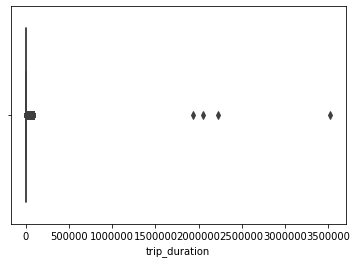

In [0]:
sns.boxplot(train_df.trip_duration) # Creates a boxplot of trip duration using 
                                    # Seaborn library.
plt.show()

In [0]:
print('there are', train_df[(train_df.trip_duration < 5)].trip_duration.count(), 'trips took less than 5 seconds, and',
      train_df[(train_df.trip_duration > 86400)].trip_duration.count(), 'trips took more than one day')

there are 845 trips took less than 5 seconds, and 4 trips took more than one day


In [0]:
# remove instances based on Duration in the testing set
# remove these 849
train_df = train_df[train_df.trip_duration >= 5]
train_df = train_df[train_df.trip_duration < 1000000]

In [0]:
train_df.shape

(1457795, 11)

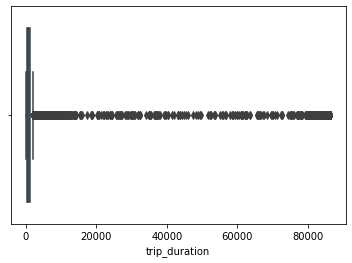

In [0]:
sns.boxplot(train_df.trip_duration)
plt.show()

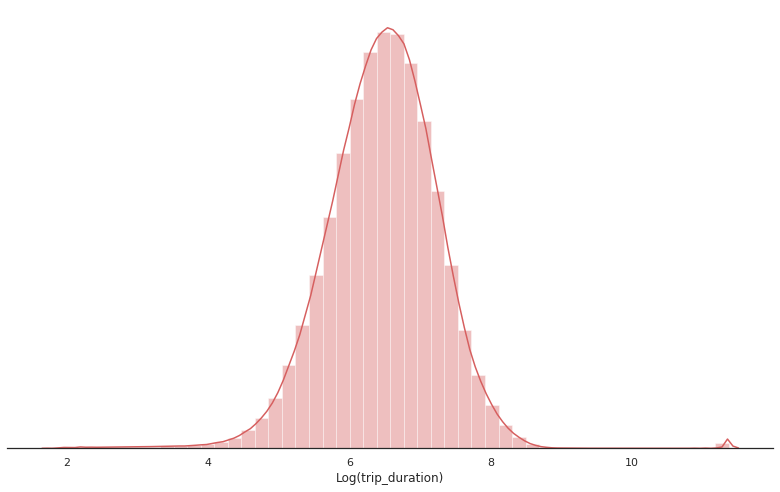

In [0]:
%matplotlib inline

# For visualization purposes, we will use the Seaborn Library

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(1, 1, figsize=(11, 7), sharex=True)
sns.despine(left=True)
sns.distplot(np.log(train_df['trip_duration'].values+1), axlabel = 'Log(trip_duration)', label = 'log(trip_duration)', bins = 50, color="r")

plt.setp(axes, yticks=[])
plt.tight_layout()
plt.show()

**Passenger Count**

In [0]:
# remove instances based on Number of Passengers in the testing set
train_df.passenger_count.value_counts()

1    1032802
2     210256
5      78070
3      59885
6      48327
4      28402
0         48
7          3
9          1
8          1
Name: passenger_count, dtype: int64

By New York legislation, rides with more than 6 passengers are ilegal, therefore, we will remove all those datapoints in addition to those rides 
with less than 1 passanger.

In [0]:
# remove these 53 trips
train_df = train_df[train_df.passenger_count <= 6]
train_df = train_df[train_df.passenger_count > 0]

In [0]:
train_df.shape # Shape of the DataFrame matrix.

(1457742, 11)

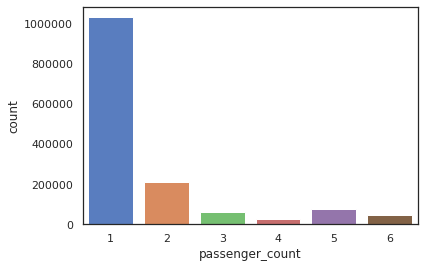

In [0]:
# Passanger count histogram.
sns.countplot(train_df.passenger_count)
plt.show()

### Distance

In [0]:
# Some useful libraries
!pip install haversine
from haversine import haversine, Unit

In [0]:
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [0]:
train_df['distance'] = train_df.apply(lambda x: calc_distance(x), axis = 1)

In [0]:
train_df.distance.describe()

count   1457742.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.10
75%           3.88
max        1240.91
Name: distance, dtype: float64

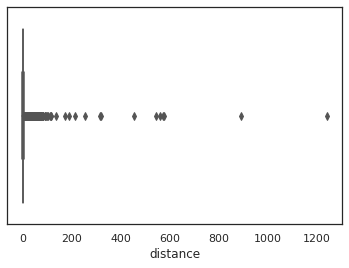

In [0]:
sns.boxplot(train_df.distance)
plt.show()

In [0]:
# remove instances based on Duration in the testing set
train_df[(train_df.distance == 0)].distance.count()

5594

In [0]:
train_df.distance.describe()

count   1457742.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.10
75%           3.88
max        1240.91
Name: distance, dtype: float64

In [0]:
train_df.nlargest(5,['distance'])

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance
184925,id2306955,1,2016-05-07 18:58:53,2016-05-07 19:12:05,1,-72.81,51.88,-73.99,40.75,N,792,1240.91
974378,id1510552,2,2016-01-06 20:40:52,2016-01-06 20:51:03,5,-71.80,35.08,-79.35,40.44,N,611,891.22
910072,id1146400,1,2016-02-15 18:57:32,2016-02-15 19:02:35,2,-73.99,40.76,-70.35,36.40,N,303,578.84
1100676,id2644780,1,2016-05-03 16:24:07,2016-05-03 17:18:34,2,-73.99,40.75,-79.52,43.92,N,3267,574.88
923793,id1001696,1,2016-02-24 21:02:32,2016-02-24 21:25:57,1,-73.97,40.76,-79.55,43.67,N,1405,562.24


There are trips with 0 distance, and as shown in the chart above, there are some points look like outliers

In [0]:
# Remove instance with distance = 0
train_df = train_df[train_df.distance != 0]

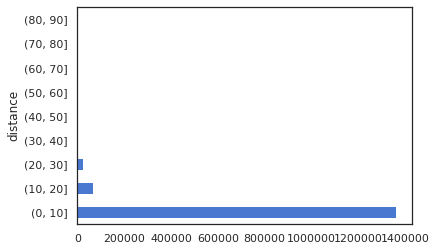

In [0]:
train_df.distance.groupby(pd.cut(train_df.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

As shown above, most of the rides are completed between 1-10 kms with some of the rides with distances between 10-30 kms

### Speed

In [0]:
train_df['speed'] = (train_df.distance/(train_df.trip_duration/3600))

In [0]:
train_df.speed.describe()

count   1452148.00
mean         14.47
std          14.76
min           0.00
25%           9.17
50%          12.82
75%          17.87
max        9274.85
Name: speed, dtype: float64

Some trips have speed more than 2,000 meter/hour, which is unrealistic. We will need to remove these instances.

In [0]:
train_df = train_df[train_df.speed <= 110]

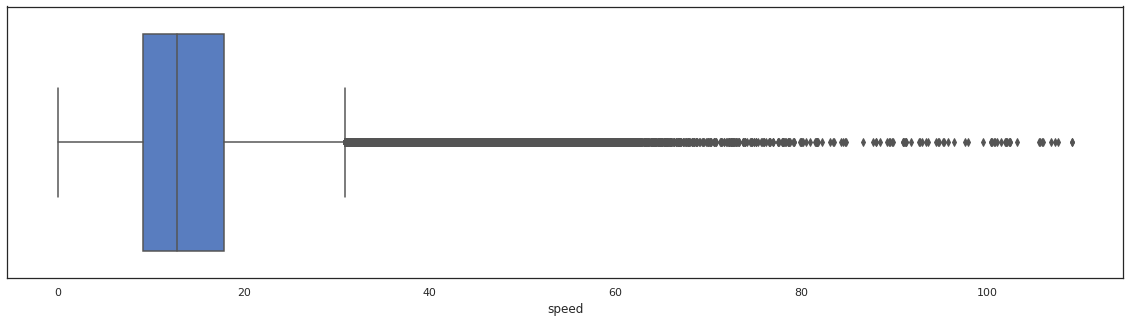

In [0]:
plt.figure(figsize = (20,5))
sns.boxplot(train_df.speed)
plt.show()

# Feature Engineering

## Time and Date

In [0]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
def convert_datetime(df):
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['weekday'] = df.pickup_datetime.dt.weekday_name
    df['month'] = df.pickup_datetime.dt.month
    df['weekday_number'] = df.pickup_datetime.dt.weekday
    df['pickup_hour'] = df.pickup_datetime.dt.hour

In [0]:
convert_datetime(train_df)
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance,speed,weekday,month,weekday_number,pickup_hour
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.98,40.77,-73.96,40.77,N,455,1.50,11.86,Monday,3,0,17
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.98,40.74,-74.00,40.73,N,663,1.81,9.80,Sunday,6,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.98,40.76,-74.01,40.71,N,2124,6.39,10.82,Tuesday,1,1,11
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01,40.72,-74.01,40.71,N,429,1.49,12.47,Wednesday,4,2,19
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.97,40.79,-73.97,40.78,N,435,1.19,9.84,Saturday,3,5,13


## Creating Dummy Variables

We can start training our model at this point. However, to add the model accuracy, we can convert our categorical data into dummy variables. We will use the function in Pandas library to make the change.

Alternatively, we could have converted the categorical data into numerical data manually or by using some Scikit Learn tools such as 

In [0]:
def create_dummy(df):
  dummy = pd.get_dummies(df.store_and_fwd_flag, prefix='flag')
  df = pd.concat([df,dummy],axis=1)

  dummy = pd.get_dummies(df.vendor_id, prefix='vendor_id')
  df = pd.concat([df,dummy],axis=1)

  dummy = pd.get_dummies(df.passenger_count, prefix='passenger_count')
  df = pd.concat([df,dummy],axis=1)

  dummy = pd.get_dummies(df.month, prefix='month')
  df = pd.concat([df,dummy],axis=1)
  
  dummy = pd.get_dummies(df.weekday_number, prefix='weekday_number')
  df = pd.concat([df,dummy],axis=1)
  
  dummy = pd.get_dummies(df.pickup_hour, prefix='pickup_hour')
  df = pd.concat([df,dummy],axis=1)
  
  return df

In [0]:
train_df = create_dummy(train_df)

In [0]:
train_df.shape

(1452035, 64)

In [0]:
# get the index of the features and label
list(zip(range(0,len(train_df.columns)),train_df.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'distance'),
 (12, 'speed'),
 (13, 'weekday'),
 (14, 'month'),
 (15, 'weekday_number'),
 (16, 'pickup_hour'),
 (17, 'flag_N'),
 (18, 'flag_Y'),
 (19, 'vendor_id_1'),
 (20, 'vendor_id_2'),
 (21, 'passenger_count_1'),
 (22, 'passenger_count_2'),
 (23, 'passenger_count_3'),
 (24, 'passenger_count_4'),
 (25, 'passenger_count_5'),
 (26, 'passenger_count_6'),
 (27, 'month_1'),
 (28, 'month_2'),
 (29, 'month_3'),
 (30, 'month_4'),
 (31, 'month_5'),
 (32, 'month_6'),
 (33, 'weekday_number_0'),
 (34, 'weekday_number_1'),
 (35, 'weekday_number_2'),
 (36, 'weekday_number_3'),
 (37, 'weekday_number_4'),
 (38, 'weekday_number_5'),
 (39, 'weekday_number_6'),
 (40, 'pickup_hour_0'),
 (41, 'pickup_hour_1'),
 (42, 'pickup_hour_2'),
 (43, 

In [0]:
# drop all the redundant columns such as pickup_datetime, weekday, month etc.
# and drop unneeded features such as id, speed (a dependant of duration)
# also seperate features with labels

X_train_set = train_df.iloc[:,np.r_[11,17:64]]
y_train_set = train_df["trip_duration"].copy()

# General equation for multiple linear regression usually includes the constant value, 
# so we will add "1" to each instance first 
X_train_set = sm.add_constant(X_train_set)
print(X_train_set.shape)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


(1452035, 49)


## Backward Feature selection


We will run linear regression multiple time by using different combination of features and check p value of each regression iteration until we reach the level of p value that is less than 5%. If the regression p value is greater than 5%, we will reject the feature from the list of array and continue with next iteration until we reach the optimal combination of features.

In [0]:
X_train_opt = X_train_set

est = sm.OLS(y_train_set, X_train_opt)
est2 = est.fit()


In [0]:
X_train_opt.shape

(1452035, 49)

In [0]:
# fetch p-value
p_Vals = est2.pvalues
print(p_Vals)

In [0]:
# Define significance level for accepting the feature.
sig_Level = 0.05

# Looping over features and remove the feature with p value less than the 5%
while max(p_Vals) > sig_Level:
    
    X_train_opt = X_train_opt.drop(X_train_opt.columns[np.argmax(np.array(p_Vals))],axis=1)

    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(np.array(p_Vals)))))
    print(str(X_train_opt.shape[1]-1) + " dimensions remaining now... \n")
    
    est = sm.OLS(y_train_set, X_train_opt)
    est2 = est.fit()
    p_Vals = est2.pvalues
    print("=================================================================\n")


In [0]:
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_train_opt.shape[1]-1)))
print(est2.pvalues)

# Modelling

## Linear Regression

### Using all features

In [0]:
# Split data from the all features
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_train_set,y_train_set, random_state=4, test_size=0.2)

In [0]:
# Linear regressor for all features
regressor0 = LinearRegression() 
regressor0.fit(X_train_all,y_train_all) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Predict from the test features of Feature Selection group
y_pred_all = regressor0.predict(X_test_all) 

### Using the selected features

In [0]:
# Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_train_opt,y_train_set, random_state=4, test_size=0.2)

In [0]:
# Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
# Predict from the test features of Feature Selection group
y_pred_fs = regressor1.predict(X_test_fs) 

In [0]:
# Evaluate the models

print('RMSE score for the Multiple LR using all features is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_all,y_pred_all))))
print('Variance score for the Multiple LR is : %.2f' % regressor0.score(X_test_all, y_test_all))
print("\n")

print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_fs))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

RMSE score for the Multiple LR using all features is : 3113.4180587693063
Variance score for the Multiple LR is : 0.03


RMSE score for the Multiple LR FS is : 3113.408582850768
Variance score for the Multiple LR FS is : 0.03




In [0]:
corr_matrix = train_df.corr()
corr_matrix["trip_duration"].sort_values(ascending=False)

## Random Forest Regression

In [0]:
# Tnstantiate() the object for the Random Forest Regressor with default params from raw data
regressor_rf_full = RandomForestRegressor(n_jobs=-1)

# Instantiate() the object for the Random Forest Regressor with default params for Feature Selection Group
regressor_rf_fs = RandomForestRegressor(n_jobs=-1)

# Train the object with default params for raw data
regressor_rf_full.fit(X_train_all,y_train_all)

# Train the object with default params for Feature Selection Group
regressor_rf_fs.fit(X_train_fs,y_train_fs)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [0]:
#Predict the output with object of default params for Feature Selection Group
y_pred_rf_full = regressor_rf_full.predict(X_test_all)

#Predict the output with object of default params for Feature Selection Group
y_pred_rf_fs = regressor_rf_fs.predict(X_test_fs)


In [0]:
type(regressor_rf_fs)

sklearn.ensemble.forest.RandomForestRegressor

In [0]:
print(np.sqrt(metrics.mean_squared_error(y_test_all,y_pred_rf_full)))
print(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf_fs)))

3479.9442814151234
3478.5577425118245
